# Lane Detection

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [44]:
def show(img):
    # Display the image
    # We habe to convert the color to display correctly
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide axis
    plt.show()

# 1. The Basics

We use an example image, that that can be desciped as f(x) = 2x and g(x) = -2x + 8. This image can "simulate" an very simple image of a road with the lanes on the left and right.

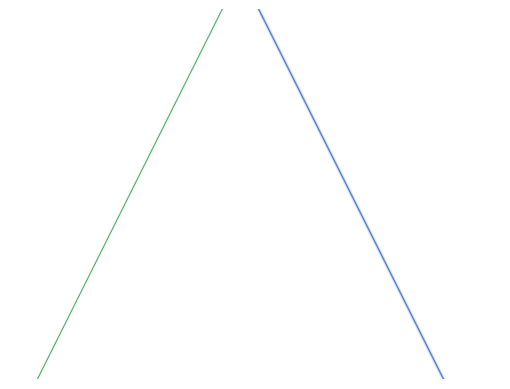

In [45]:
img = cv2.imread("../Test_Image.png")
show(img)

Canny Edge Detection now takes the image and return an image with edges. We can set the upper and lower thrashold.
We also can make the image gray and blur it, to reduce noise.

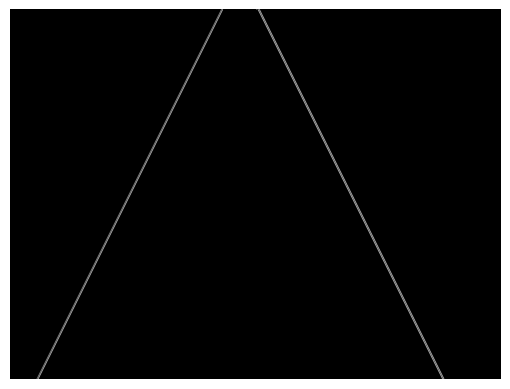

In [46]:
grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(grayscale, (5, 5), 0)
edges = cv2.Canny(img, 50, 150)

# we have to convert the color so we can show the image correct
show(edges)

Now we want to get the lines out of the image. So instead of an whole image, we only want an array of all the lines.
To achive this, we use probabilistic Hough transform. (It is wise to do edge detection first.)

In [47]:
# Distance resolution of the accumulator in pixels.
rho = 1             
# Angle resolution of the accumulator in radians.
theta = np.pi/180   
# Only lines that are greater than threshold will be returned.
threshold = 20      
# Line segments shorter than that are rejected.
minLineLength = 20  
# Maximum allowed gap between points on the same line to link them
maxLineGap = 500    
# function returns an array containing dimensions of straight lines 
# appearing in the input image
lines = cv2.HoughLinesP(edges, rho = rho, theta = theta, threshold = threshold,
                        minLineLength = minLineLength, maxLineGap = maxLineGap)

print(lines)
print(len(lines))

[[[609 104 874 626]]

 [[555   1 949 776]]

 [[566  18 822 522]]

 [[142 674 321 309]]

 [[ 64 830 238 475]]

 [[834 554 939 762]]

 [[564   8 670 218]]

 [[250 458 429  93]]

 [[296 366 475   1]]

 [[373 212 453  50]]

 [[558   0 760 398]]

 [[900 686 973 831]]

 [[192 574 371 209]]

 [[794 474 975 830]]

 [[122 714 185 581]]

 [[ 87 778 147 657]]

 [[425 108 478   0]]

 [[736 358 976 830]]

 [[ 75 802  96 759]]

 [[337 284 476   0]]

 [[562   4 593  64]]

 [[ 61 830  77 797]]

 [[561   2 578  34]]

 [[114 730 170 611]]]
24


We see, that we detect a lot of lines. This can be reduced by tweeking the parameters. But even with that, sometimes the algorithmus detects many lines that correspont to the same line.

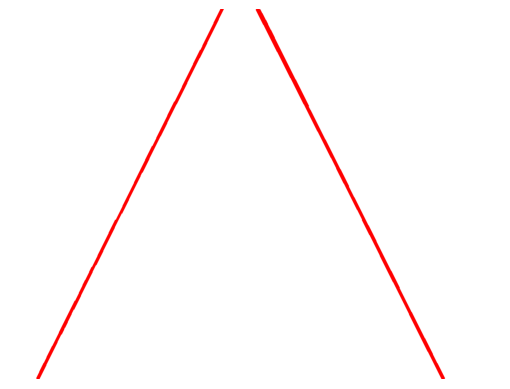

In [48]:
# create a copy on the image to keep the original
img_lines = img.copy()

for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(img_lines, (x1, y1), (x2, y2), (0, 0, 255), 3)
show(img_lines)

When drawed, we can see that we detect only the lines, but in multiple sections and some sections are even the same.
Thats why we now calculate the average of the slope and intercept of all lines.
(Note that we calculate a left and right average slope and intercept, because we want to get 2 lines. These lines differe in the sign of the slope.)

In [49]:
def average_slope_intercept(lines):
    left_lines    = [] #(slope, intercept)
    left_weights  = [] #(length,)
    right_lines   = [] #(slope, intercept)
    right_weights = [] #(length,)
    
    for line in lines:
        # hough line transform places the corrdinats in douple brackets -> [[x1,y1,x2,y2]]
        x1, y1, x2, y2 = line[0] 
        if x1 == x2:
            continue
        # linear function: y = a * x + b
        # calculating slope of a line
        slope = (y2 - y1) / (x2 - x1)
        # calculating intercept of a line
        # y = a * x + b to b
        intercept = y1 - (slope * x1)
        # calculating length of a line
        length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
        # slope of left lane is negative and for right lane slope is positive
        if slope < 0:
            left_lines.append((slope, intercept))
            left_weights.append((length))
        else:
            right_lines.append((slope, intercept))
            right_weights.append((length))
    # 
    left_lane  = np.dot(left_weights,  left_lines) / np.sum(left_weights)  if len(left_weights) > 0 else None
    right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
    return left_lane, right_lane

In this example, we habe a slope of 1 and an inerception of 1. Because we have only one line that increases, the output must be None for the left lane and [1, 1] for the right lane. The linear function is: y = 1x + 1 where 1 is slope and 1 is interception.

In [50]:
test_lines = [[[1,2,3,4]]]
ll, rl = average_slope_intercept(test_lines)
print(f"Left: {ll}, Right: {rl}")

Left: None, Right: [1. 1.]


In this example, we now look what the average slope and interception means.
We take the two functions 1x and 3x with the x values 1 and 2.

In [51]:
test_lines = [[[1,1,2,2]], [[1,3,2,6]]]
ll, rl = average_slope_intercept(test_lines)
print(f"Left: {ll}, Right: {rl}")

Left: None, Right: [2.38196601 0.        ]


The output is 2.38 for the slope and 0 for the interception. The 0 is obvious, because our two functions didnt have one.
The slope is diffrent. Because the middle line, so the line between 1x and 3x should be 2x. But than we loose valuebal information. To be percize: We loos the lengh of each line. Because we want to detect lanes, we know that longe lines are more valuable than short lines. Short lines may be shadows or other objects like cars, that are not a lane. Longe lines on the other hand could indicate a lane. Thats why there are more importent.
Doing the same example from above, but increase the x values for 1x from 1 and 2 to 1 and 200, make the average slope go closer to the 1x function, because it seems more important in comperision to the 3x with 1 and 2 as x values.

In [52]:
test_lines = [[[1,1,200,200]], [[1,3,2,6]]]
ll, rl = average_slope_intercept(test_lines)
print(f"Left: {ll}, Right: {rl}")

Left: None, Right: [1.02222333 0.        ]


In our example, we can apply this function:

In [53]:
ll, rl = average_slope_intercept(lines)
print(f"Left: {ll}, Right: {rl}")

Left: [ -2.04520842 966.37761793], Right: [    1.96903114 -1094.13191249]


Now we got some lanes. But we lost valuable data, because now we dont know where the lane started and ended. So we have calculate the x coordinats of our lanes with some self choosen y coordinats.

In [54]:
img.shape

(832, 1105, 3)

In [55]:
# Note that ll or rl can be none
if ll is None or rl is None:
    pass

# the first value of ll or rl is the slope, the secondt the intercept
y1 = img.shape[0]
y2 = 0
x1 = int((y1 - ll[1]) / ll[0])
x2 = int((y2 - ll[1]) / ll[0])
left_lane = [x1, y1, x2, y2]

# for pixels, we need whole numbers
x1 = int((y1 - rl[1]) / rl[0])
x2 = int((y2 - rl[1]) / rl[0])
right_lane = [x1, y1, x2, y2]

print(f"Left: {left_lane}, Right: {right_lane}")

Left: [65, 832, 472, 0], Right: [978, 832, 555, 0]


Now we can draw the lanes on the original image.

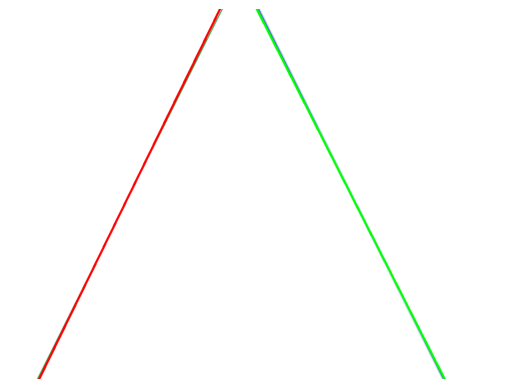

In [56]:
img_result = img.copy()
cv2.line(img_result, (left_lane[0], left_lane[1]), (left_lane[2], left_lane[3]), (0, 0, 255), 3)
cv2.line(img_result, (right_lane[0], right_lane[1]), (right_lane[2], right_lane[3]), (0, 255, 0), 3)
show(img_result)

The last thing that must be done is to draw a line in the center of the lanes, wehre the vehicle should drive.
For that, we can calculate a function that runns through the middle.
We know that the midpoint is x3 = (x1 + x2) / 2 and y3 = (y1 + y2) / 2. We can make a function out of it and calculate the middle lane.

In [57]:
xm1 = int((left_lane[0] + right_lane[0]) / 2)
xm2 = int((left_lane[2] + right_lane[2]) / 2)
middle_lane = [xm1, y1, xm2, y2]

print(f"M: {middle_lane}")

M: [521, 832, 513, 0]


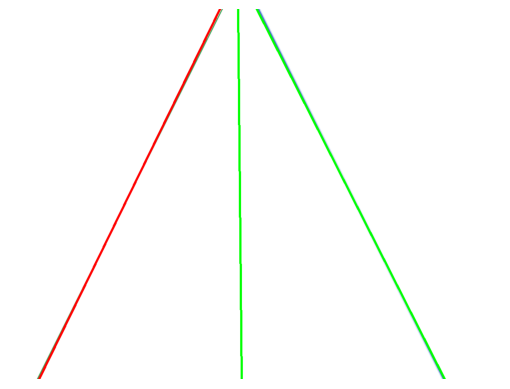

In [58]:
cv2.line(img_result, (middle_lane[0], middle_lane[1]), (middle_lane[2], middle_lane[3]), (0, 255, 0), 3)
show(img_result)

Now we can pack this in one cell. We made a function out of the code, so we can run it multiple times and create multiple versions if needed.

In [59]:
def detectLanes_v1(img):

    output_img = img.copy()

    # image processing
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.Canny(img, 50, 150)

    # get the lines
    lines = cv2.HoughLinesP(img, rho = 1, theta = np.pi/180, threshold = 20, minLineLength = 20, maxLineGap = 500)
    
    # average the lines to one left, one right 
    left_lines    = [] 
    left_weights  = [] 
    right_lines   = [] 
    right_weights = [] 

    for line in lines:

        x1, y1, x2, y2 = line[0] 
        if x1 == x2:
            continue

        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - (slope * x1)
        length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))

        if slope < 0:
            left_lines.append((slope, intercept))
            left_weights.append((length))
        else:
            right_lines.append((slope, intercept))
            right_weights.append((length))

    ll  = np.dot(left_weights,  left_lines) / np.sum(left_weights)  if len(left_weights) > 0 else None
    rl = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None

    # get coordinats in pixels from the slope / intercept
    if ll is None or rl is None:
        pass

    y1 = img.shape[0]
    y2 = 0
    x1 = int((y1 - ll[1]) / ll[0])
    x2 = int((y2 - ll[1]) / ll[0])
    left_lane = [x1, y1, x2, y2]

    x1 = int((y1 - rl[1]) / rl[0])
    x2 = int((y2 - rl[1]) / rl[0])
    right_lane = [x1, y1, x2, y2]

    # calculate the center of both lines
    xm1 = int((left_lane[0] + right_lane[0]) / 2)
    xm2 = int((left_lane[2] + right_lane[2]) / 2)
    middle_lane = [xm1, y1, xm2, y2]

    cv2.line(output_img, (left_lane[0], left_lane[1]), (left_lane[2], left_lane[3]), (0, 0, 255), 3)
    cv2.line(output_img, (right_lane[0], right_lane[1]), (right_lane[2], right_lane[3]), (255, 0, 0), 3)
    cv2.line(output_img, (middle_lane[0], middle_lane[1]), (middle_lane[2], middle_lane[3]), (0, 255, 0), 3)

    return output_img

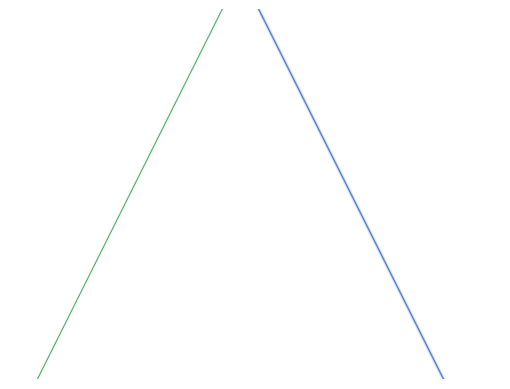

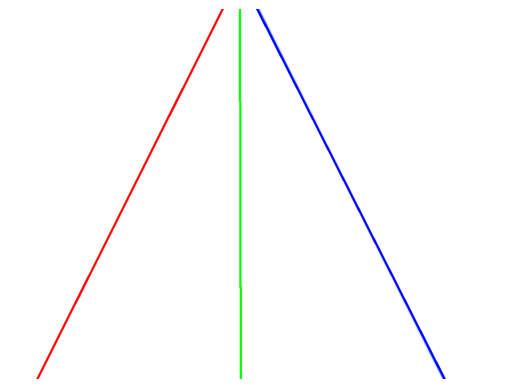

In [60]:
img = cv2.imread("../Test_Image.png")
show(img)
show(detectLanes_v1(img))

Now lets test it on a real example.

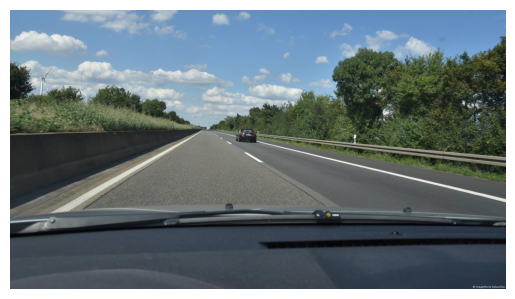

Size: (1080, 1920, 3)


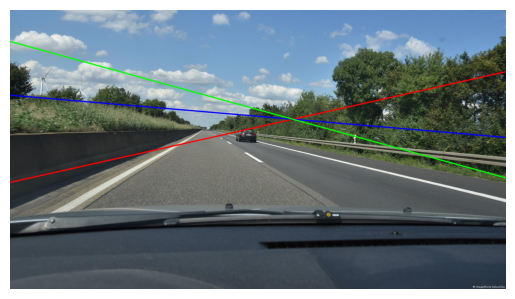

In [61]:
img = cv2.imread("../Real_Test.jpg")
show(img)
print(f"Size: {img.shape}")
show(detectLanes_v1(img))

It workes, but not really good. Thats because we detect multiple edges and therefore lines that are diffrent objects or aritfacts.

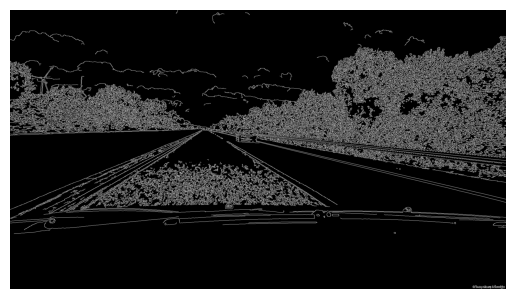

In [62]:
show(cv2.Canny(img, 50, 150))